In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from tpot import TPOTClassifier
from collections import Counter
from imblearn.under_sampling import ClusterCentroids

In [2]:
df = pd.read_csv('./diabetes_readmission/diabetic_data.csv').sample(frac=1)

df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2279,14897280,2025,Caucasian,Female,[70-80),?,2,3,1,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
85190,269637468,66457080,Caucasian,Male,[60-70),?,1,6,7,8,...,No,Steady,No,No,No,No,No,No,Yes,<30
26715,87867120,29318211,Caucasian,Male,[60-70),?,1,3,17,10,...,No,Down,No,No,No,No,No,Ch,Yes,>30
98347,399649946,133615958,Caucasian,Female,[50-60),?,1,1,7,4,...,No,Steady,No,No,No,No,No,No,Yes,NO
83226,260354784,84684438,Caucasian,Female,[70-80),?,1,3,7,5,...,No,No,No,No,No,No,No,No,No,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56049,161337000,89346753,Caucasian,Female,[70-80),?,3,1,1,2,...,No,No,No,No,No,No,No,No,Yes,>30
95525,363108080,131743238,Caucasian,Male,[40-50),?,3,1,6,6,...,No,No,No,No,No,No,No,No,No,>30
96956,382562354,120899255,Caucasian,Female,[80-90),?,2,1,7,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
66421,185535426,41777082,Caucasian,Female,[40-50),?,1,1,7,2,...,No,Down,No,No,No,No,No,Ch,Yes,>30


In [3]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [4]:
df = df[['race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']]

In [5]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('readmitted')
cat_cols

['pioglitazone',
 'age',
 'metformin',
 'glimepiride-pioglitazone',
 'glyburide',
 'diag_3',
 'tolazamide',
 'diag_2',
 'glipizide',
 'chlorpropamide',
 'diabetesMed',
 'repaglinide',
 'change',
 'troglitazone',
 'insulin',
 'medical_specialty',
 'metformin-rosiglitazone',
 'glimepiride',
 'citoglipton',
 'weight',
 'glyburide-metformin',
 'acarbose',
 'race',
 'acetohexamide',
 'gender',
 'tolbutamide',
 'nateglinide',
 'A1Cresult',
 'rosiglitazone',
 'diag_1',
 'payer_code',
 'miglitol',
 'glipizide-metformin',
 'metformin-pioglitazone',
 'examide',
 'max_glu_serum']

In [6]:
df['readmitted'].value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

In [7]:
df = df.replace({'readmitted': {
    'NO': 0,
    '>30': 1,
    '<30': 1
}})

df

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2279,Caucasian,Female,[70-80),?,2,3,1,12,?,InternalMedicine,...,No,Steady,No,No,No,No,No,Ch,Yes,0
85190,Caucasian,Male,[60-70),?,1,6,7,8,BC,?,...,No,Steady,No,No,No,No,No,No,Yes,1
26715,Caucasian,Male,[60-70),?,1,3,17,10,MC,?,...,No,Down,No,No,No,No,No,Ch,Yes,1
98347,Caucasian,Female,[50-60),?,1,1,7,4,SP,?,...,No,Steady,No,No,No,No,No,No,Yes,0
83226,Caucasian,Female,[70-80),?,1,3,7,5,MC,?,...,No,No,No,No,No,No,No,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56049,Caucasian,Female,[70-80),?,3,1,1,2,MC,Pulmonology,...,No,No,No,No,No,No,No,No,Yes,1
95525,Caucasian,Male,[40-50),?,3,1,6,6,MC,?,...,No,No,No,No,No,No,No,No,No,1
96956,Caucasian,Female,[80-90),?,2,1,7,3,MC,Emergency/Trauma,...,No,Steady,No,No,No,No,No,No,Yes,1
66421,Caucasian,Female,[40-50),?,1,1,7,2,SP,?,...,No,Down,No,No,No,No,No,Ch,Yes,1


In [8]:
df_revised = pd.get_dummies(df, columns=cat_cols)
df_revised

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,miglitol_Steady,miglitol_Up,glipizide-metformin_No,glipizide-metformin_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,examide_No,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm
2279,2,3,1,12,47,2,18,0,0,0,...,False,False,True,False,True,False,True,False,False,False
85190,1,6,7,8,54,0,20,0,0,0,...,False,False,True,False,True,False,True,False,False,False
26715,1,3,17,10,25,0,10,0,0,0,...,False,False,True,False,True,False,True,False,False,True
98347,1,1,7,4,60,0,11,0,0,0,...,False,False,True,False,True,False,True,False,False,False
83226,1,3,7,5,28,0,10,3,0,0,...,False,False,True,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56049,3,1,1,2,64,1,13,0,0,0,...,False,False,True,False,True,False,True,False,False,False
95525,3,1,6,6,35,1,26,0,0,1,...,False,False,True,False,True,False,True,False,False,False
96956,2,1,7,3,1,1,10,0,0,0,...,False,False,True,False,True,False,True,False,False,False
66421,1,1,7,2,38,0,16,0,0,2,...,False,False,True,False,True,False,True,False,False,False


In [9]:
X = df_revised.drop('readmitted', axis=1)
y = df_revised['readmitted']

X.shape, y.shape

((101766, 2468), (101766,))

In [10]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, encoded_y, test_size=0.2, shuffle=True)

In [12]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

X_res.shape, y_res.shape

((87870, 2468), (87870,))

In [13]:
scaler = StandardScaler()
training_scaled_features = scaler.fit_transform(X_res)
test_scaled_features = scaler.transform(X_test)

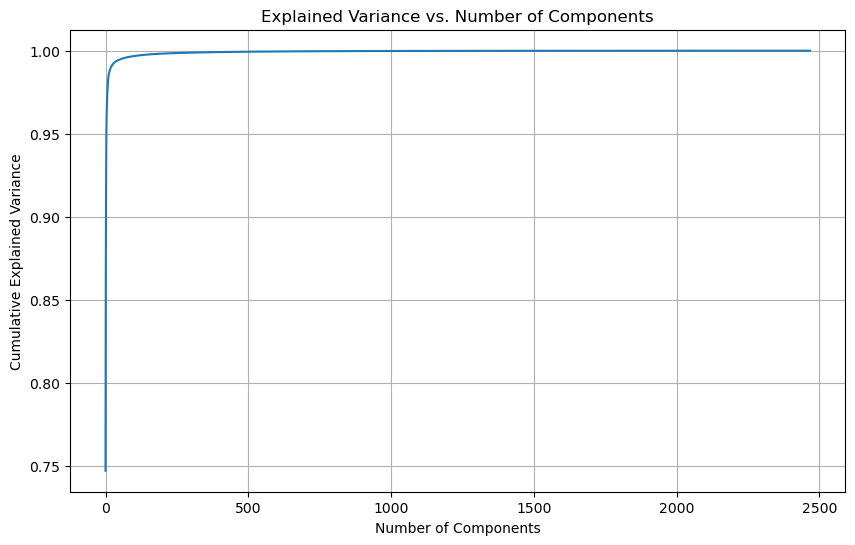

In [19]:
pca_full = PCA()
pca_full.fit(X_res)

cumulative_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [15]:
pca = PCA(n_components=20)
X_res_pca = pca.fit_transform(X_res)
X_test_pca = pca.transform(X_test)

exp_var_pca = pca.explained_variance_ratio_
exp_var_pca

array([7.47300442e-01, 1.19094377e-01, 5.20552158e-02, 3.09999336e-02,
       1.20295709e-02, 6.72496106e-03, 4.83091616e-03, 3.52178039e-03,
       3.21659281e-03, 2.75657771e-03, 1.50637767e-03, 1.41207454e-03,
       9.20944867e-04, 7.03059312e-04, 6.63992501e-04, 5.40212644e-04,
       5.01077383e-04, 4.79588686e-04, 4.30428204e-04, 3.93200581e-04])

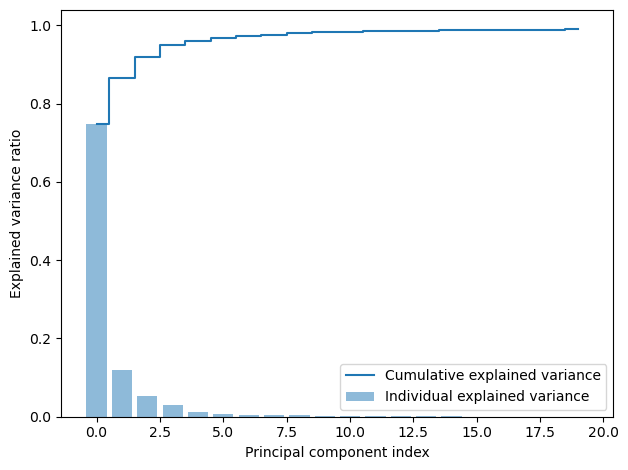

In [16]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, n_jobs=1)
tpot.fit(X_res_pca, y_res)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6289290998065323

Generation 2 - Current best internal CV score: 0.6294298395356778

Generation 3 - Current best internal CV score: 0.6299419597132128

Generation 4 - Current best internal CV score: 0.633071583020371

Generation 5 - Current best internal CV score: 0.633071583020371

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=1.0, min_samples_leaf=3, min_samples_split=12, n_estimators=100)


TPOTClassifier(generations=5, population_size=50, verbosity=2)

In [18]:
y_pred = tpot.predict(X_test_pca)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy Score: 0.6278372801414955

              precision    recall  f1-score   support

           0       0.65      0.66      0.66     10929
           1       0.60      0.59      0.59      9425

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.63      0.63     20354

